# Кривая выживаемости. Обучение.

**Кривая выживаемости, survival curve** — **кривая продолжительности жизни** — **Кривая смертности** — показывает долю особей определённой группы доживших до определённого возраста.

Зачем нужно использовать кривую выживаемости? Что бы увидеть, как интервенция изменила максимальную продолжительность жизни и на сколько.

**Цели**

- Посмотреть динамику выживаемости группы особей при нормальных условиях
- Определить изменение динамики выживаемости группы особей после интервенции
- Сравнить нормальную выживаемость и после интервенции

Текущие задачи:
- Посмотреть видео "[Кривые дожития, Закон Гомпертца и корреляция Стрелера—Милдвана [Aging Math]](https://youtu.be/kdO44AO4l-4)"
  - можно ли проверять модели не на выживаемости, а на интенсивности старения (не дожидаясь смерти особи)? Как её померить?
- Посмотреть файл "[Кривые дожития, Закон Гомпертца, старение и корреляция Стрелера—Милдвана.ipynb](https://colab.research.google.com/drive/1Po-OMzIJ_4hVVj5O7btc8OmjJlu0N3cQ)"
  - нет всех названий графиков, каждой оси графиков, легенды графика из-за чего график не понятен с первого взгляда — сделать все подписи для своих графиков
  - на первом графике с оранжевой и синей кривой, синяя получается это кривая смерти, раз она без старения?
  - графики показывают скорость старения, можно ли померить естественную скорость омоложения? Это будет скорость обновления? Скорость репарации? Как понять на сколько скорость старения сильно отличается от скорости омоложения.
- Определить в эксперименте с 2 группами особей, не обязательно равного размера по количеству, какая живет лучше и дольше
- Сделать с группами следующее:
  1. Посчитать оценку Каплана-Майера (Kaplan–Meier estimator)
  2. Посчитать тест Колмогорова-Смирнова (Kolmogorov–Smirnov test)
  3. Посчитать Log-rank test
  4. Сравнить результаты, понять отличие
  5. Оценить нормальность распределения

  кривая дожития есть кривая смертности и посмотреть производные

**Необходимые знания**

- Основы теории вероятностей

**Сравнение существующих решений для анализа кривых выживаемости в виде Python-пакетов с помощью [piptrends](https://piptrends.com/compare/lifelines-vs-scikit-survival-vs-survival):**
- [lifelines](https://github.com/CamDavidsonPilon/lifelines) ([документация](https://lifelines.readthedocs.io/en/latest/))
- [scikit-survival](https://github.com/sebp/scikit-survival) ([документация](https://scikit-survival.readthedocs.io/en/stable/index.html))
- [survival](https://github.com/ryu577/survival)

In [198]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib.ticker import MultipleLocator
from scipy.stats import gamma, kstest
from sklearn import preprocessing

## Получаем исходные данные

In [376]:
original_df = pd.read_csv('../data/data_example.csv')
df = original_df.copy()
df

,day,first_group_count,second_group_count
0,1,244,297
1,2,244,297
2,3,244,297
3,4,244,297
4,5,244,297
...,...,...,...
85,86,0,0
86,87,0,0
87,88,0,0
88,89,0,0


❓ Что делать когда количество особей в группах разное?

## Приводим данные к нужному виду

[Getting data in the right format](https://lifelines.readthedocs.io/en/latest/Quickstart.html#getting-data-in-the-right-format)

Формат данных необходим такой:

|количество оставшихся особей |день наблюдения|название группы особей|
|---|---|---|
|целое число|целое число|число или строка|

In [377]:
# Размещаем один столбец под другим вместе с обозначением группы и днями
df_fg = pd.DataFrame({'count': df['first_group_count'], 'day': df['day'].values, 'group': 1})
df_sg = pd.DataFrame({'count': df['second_group_count'], 'day': df['day'].values, 'group': 2})
df = pd.concat([df_fg, df_sg])
df

,count,day,group
0,244,1,1
1,244,2,1
2,244,3,1
3,244,4,1
4,244,5,1
...,...,...,...
85,0,86,2
86,0,87,2
87,0,88,2
88,0,89,2


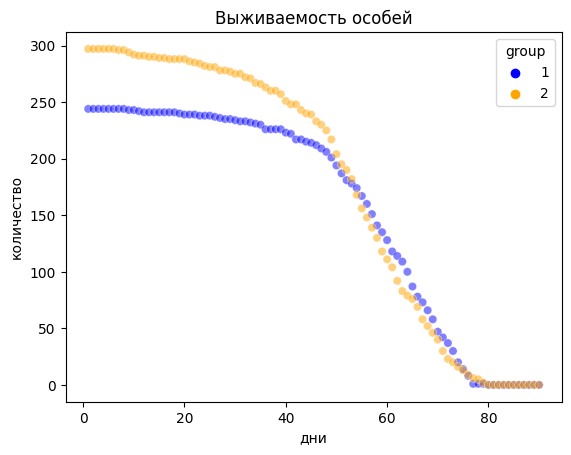

In [378]:
g = sns.scatterplot(data=df[df['group'] == 1], x='day', y='count', hue='group', palette=['blue'], alpha=0.5);
sns.scatterplot(data=df[df['group'] == 2], x='day', y='count', hue='group', palette=['orange'], alpha=0.5);

g.set(xlabel='дни', ylabel='количество')
g.set(title='Выживаемость особей')
plt.show();

## Гипотеза

Нулевая гипотеза $H_0$ — выживаемость одинаковая, различия случайны  
Альтернативная гипотеза $H_1$ — выживаемость разная, различия статистически значимы

## Метод Каплана-Майера

❗ Добавить описание теста

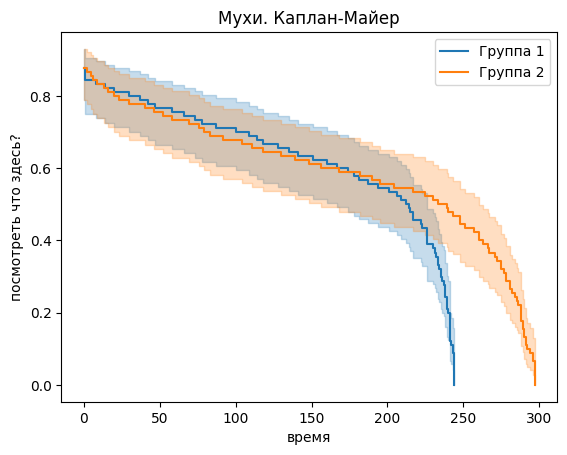

In [284]:
kmf = KaplanMeierFitter()

# Продолжительность в течении которой субъект был жив для каждой из групп
duration_group_one = df.loc[df['group'] == 1, 'count']
duration_group_two = df.loc[df['group'] == 2, 'count']

kmf.fit(duration_group_one, label='Группа 1')
ax = kmf.plot_survival_function()

kmf.fit(duration_group_two, label='Группа 2')
ax = kmf.plot_survival_function(ax=ax)

ax.set_title('Мухи. Каплан-Майер')
ax.set_xlabel('время')
ax.set_ylabel('посмотреть что здесь?');

❓ Говоря простым языком мы наглядно показали что старение двух разных групп особей отличается. В данном случае это благодаря вмешательству.

## Тест Колмогорова-Смирнова

❗ Добавить описание теста

In [379]:
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5

def cdf(sample, x, sort = False):
    # Sorts the sample, if unsorted
    if sort:
        sample.sort()
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    return cdf

def ks_2samp(sample1, sample2):
    """Тест Колмогорова-Смирнова"""
    # Gets all observations
    observations = np.concatenate((sample1, sample2))
    observations.sort()
    # Sorts the samples
    sample1.sort()
    sample2.sort()
    # Evaluates the KS statistic
    D_ks = [] # KS Statistic list
    for x in observations:
        cdf_sample1 = cdf(sample = sample1, x  = x)
        cdf_sample2 = cdf(sample = sample2, x  = x)
        D_ks.append(abs(cdf_sample1 - cdf_sample2))
    ks_stat = max(D_ks)
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(len(sample1)), float(len(sample2))
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(ks_stat, np.round(en))
    return {"ks_stat": ks_stat, "p_value" : p_value}

In [380]:
kstest(duration_group_one.values, duration_group_two.values)

KstestResult(statistic=0.4666666666666667, pvalue=3.1801997900183795e-09)

In [381]:
ks_2samp(duration_group_one.values, duration_group_two.values)

{'ks_stat': 0.4666666666666667, 'p_value': 1.6753232154714445e-09}

❓ Два варианта теста показывают разные p-value

❓ Если получившееся p-value, а это не меньше 0.05, значит отвергаем нулевую, принимаем альтернативную гипотезу — то есть выживаемость разная, отличия значимы.

## Log-rank тест

❗ Добавить описание теста

In [283]:
results = logrank_test(duration_group_one, duration_group_two, alpha=.99)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          27.46 <0.005     22.57

❗ Добавить описание результата 